# **Modelo LSTM en diferido Stateful. One-Future step**

El modelo no se entrena con las etiquetas de 2017 porque se usarán para testearlo. Se usan las etiquetas de **WT1**. La conclusión que se extrae de este script es que la turbina eólica 1 no tiene una distribución coherente de las etiquetas en el año de 2017 que se usa en la fase de prueba.

## **Importación**

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from numpy import array
from numpy import newaxis

#Data Split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

#Neuronal Network API
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, LSTM, Dense, BatchNormalization, Dropout
from keras.models import load_model
import plotly.graph_objects as go

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import os
import collections

In [ ]:
%matplotlib inline
print(plt.style.available)
plt.style.use('seaborn-v0_8')

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Lectura de los datos**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/TFG_modelado/UNET/resultados_Carlos/etiq_Carlos_8x8_3D_prediccion.csv')
df_wt1_completo = df[df["Id"] == 1] # Nos quedamos con los datos de la turbina eolica 1

In [ ]:
df_wt1_completo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31167 entries, 0 to 31166
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   etiqueta_rendimiento  31167 non-null  int64 
 1   Id                    31167 non-null  int64 
 2   Fecha_Inicio          31167 non-null  object
 3   Fecha_Fin             31167 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.2+ MB


In [ ]:
df_wt1_completo.head(1)

,etiqueta_rendimiento,Id,Fecha_Inicio,Fecha_Fin
0,5,1,2009-07-08 15:20:00,2009-07-09 02:30:00


In [ ]:
df_wt1_completo.tail(1)

,etiqueta_rendimiento,Id,Fecha_Inicio,Fecha_Fin
31166,1,1,2017-03-10 02:20:00,2017-03-10 13:00:00


In [ ]:
# Número de etiquetas por año
años = pd.DataFrame()

años['Fecha_Inicio'] = pd.to_datetime(df_wt1_completo['Fecha_Inicio'])
años['Fecha_Fin'] = pd.to_datetime(df_wt1_completo['Fecha_Fin'])

# Extraemos el año de la columna 'inicio' y contamos las ocurrencias
conteo_por_año = años['Fecha_Inicio'].dt.year.value_counts().sort_index()

print(conteo_por_año)

2009    1863
2010    4061
2011    4074
2012    4083
2013    4083
2014    4069
2015    4068
2016    4097
2017     769
Name: Fecha_Inicio, dtype: int64


## **Division de los datos en training set y test set**

In [ ]:
df_wt1_completo_copy = df_wt1_completo.copy()

# Convertimos las columnas de fecha en objetos datetime
df_wt1_completo_copy['Fecha_Inicio'] = pd.to_datetime(df_wt1_completo_copy['Fecha_Inicio'])
df_wt1_completo_copy['Fecha_Fin'] = pd.to_datetime(df_wt1_completo_copy['Fecha_Fin'])

# Filtramos las filas del año 2017
df_testing_2017 = df_wt1_completo_copy[df_wt1_completo_copy['Fecha_Inicio'].dt.year == 2017]

# Filtramos las filas excepto las del año 2017
df_training = df_wt1_completo_copy[df_wt1_completo_copy['Fecha_Inicio'].dt.year != 2017]

In [ ]:
print("Numero de etiquetas de entrenamiento: " + str(len(df_training)))
print("Numero de etiquetas de prueba: " + str(len(df_testing_2017)))

Numero de etiquetas de entrenamiento: 30398
Numero de etiquetas de prueba: 769


In [ ]:
dataset_training = df_training["etiqueta_rendimiento"].to_numpy()
performance_training = df_training["etiqueta_rendimiento"].to_numpy()

dataset_testing = df_testing_2017["etiqueta_rendimiento"].to_numpy()
performance_testing = df_testing_2017["etiqueta_rendimiento"].to_numpy()

dataset_training = dataset_training.reshape(-1, 1)
dataset_testing = dataset_testing.reshape(-1, 1)

**Normalización** training set

In [ ]:
print("Valores sin normalizar: " + str(dataset_training[0]) + str(dataset_training[1]) + str(dataset_training[2]) + str(dataset_training[3]) + str(dataset_training[4]))

Valores sin normalizar: [5][1][5][1][5]


In [ ]:
# Normalización
scaler = MinMaxScaler()
dataset_training_n = scaler.fit_transform(dataset_training)

In [ ]:
print("Valores normalizados: " + str(dataset_training_n[0]) + str(dataset_training_n[1]) + str(dataset_training_n[2]) + str(dataset_training_n[3]) + str(dataset_training_n[4]))

Valores normalizados: [1.][0.2][1.][0.2][1.]


**Normalización** test set

In [ ]:
print("Valores sin normalizar: " + str(dataset_testing[0]) + str(dataset_testing[1]) + str(dataset_testing[2]) + str(dataset_testing[3]) + str(dataset_testing[4]))

Valores sin normalizar: [1][1][1][1][1]


In [ ]:
# Normalización
dataset_testing_n = scaler.transform(dataset_testing)

In [ ]:
print("Valores normalizados: " + str(dataset_testing_n[0]) + str(dataset_testing_n[1]) + str(dataset_testing_n[2]) + str(dataset_testing_n[3]) + str(dataset_testing_n[4]))

Valores normalizados: [0.2][0.2][0.2][0.2][0.2]


## **Creación secuencias**

In [ ]:
# split a univariate sequence into samples. Targets isnt normalized
def split_sequence(sequence, targets, n_steps_in, n_steps_out, stride = None):
  if stride is  None:
    stride = 1
  X, y = list(), list()
  for i in range(0, len(sequence), stride):
    # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    # check if we are beyond the sequence
    if out_end_ix > len(sequence):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], targets[end_ix:out_end_ix]
    X.append(seq_x)
    if n_steps_out == 1:
      y.append(seq_y[0])  # Si solo hay un paso de salida, añadir solo el valor
    else:
      y.append(seq_y)
  return array(X), array(y)

In [ ]:
sequence_length = 65
output_steps = 1
batch_size = 1

In [ ]:
X_train, y_train = split_sequence(dataset_training, performance_training, sequence_length, output_steps, stride = sequence_length)
# Ejemplo de pintar por pantalla dos secuencias ejemplo junto con su etiqueta objetivo
contador = 0
for i in range(len(X_train)):
 print(f"### Secuencia [{i}] de entrenamiento ###")
 print(' '.join([str(step) for step in X_train[i]]))
 print(f"Predicción: {[str(step) for step in [y_train[i]]]}")
 contador = contador + 1

 if(contador == 2):
  break

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Crear un dataset a partir de los tensores
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# Divide en lotes de tamaño batch_size:
train_dataset = train_dataset.batch(batch_size)

print(f"Número de batches train = secuencias: {sum(1 for _ in train_dataset)}")

### Secuencia [0] de entrenamiento ###
[5] [1] [5] [1] [5] [3] [5] [5] [5] [5] [5] [5] [1] [5] [1] [1] [5] [1] [1] [2] [5] [5] [5] [5] [2] [1] [2] [1] [1] [1] [2] [2] [2] [2] [1] [2] [1] [2] [2] [1] [1] [1] [2] [1] [2] [1] [1] [2] [1] [2] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1]
Predicción: ['1']
### Secuencia [1] de entrenamiento ###
[1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [2] [2] [2] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [2] [2] [2] [5] [4] [1] [2] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1] [1]
Predicción: ['1']
Número de batches train = secuencias: 467


In [ ]:
def visualization (history):

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.title('Model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='best')
  plt.show()

  # summarize history for MAE
  plt.plot(history.history['mae'])
  plt.title('Model MAE')
  plt.ylabel('MAE')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='best')
  plt.show()

## Funciones **Prediccion** y plotting
Las siguientes dos funciones predicen una secuencia de pasos futuro. *prediccion_secuencias_multiples* predice varias secuencias multiples, mientras que *prediccion_secuencia_completa* predice toda la secuencia acumulando el error.

### Prediccion **multiple sequences**

In [ ]:
### prediction_len: numero de valores que conforman una secuencia predicha
### dataset: es la serie temporal de etiquetas
### output_steps: es el numero de steps futuros predichos por el modelo dada una Secuencia
### window_size es la longitud de cada secuencia
### n_sequences: indica el numero de secuencias a predecir. None para predecir todas las del dataset

def prediccion_secuencias_multiples(prediction_len, dataset, output_steps, window_size, n_sequences):

  # Inicializar la lista para almacenar las predicciones
  prediction_seqs = []
  curr_frame = []
  stop_point = len(dataset) - window_size

  contador = 0

  # Iterar sobre el conjunto de datos con un paso de 50
  for i in range(0, stop_point, prediction_len):
      contador = contador + 1

      # Obtener la secuencia actual
      curr_frame = dataset[i:i+window_size]
      predicted_seq = [] # Inicializar una lista para almacenar las predicciones de esta secuencia

      # print("### SECUENCIA" + str(len(curr_frame2)))
      # print(curr_frame2)

      for j in range(prediction_len): # Hacer predicciones de 40 valores de salida
          # print("### Iteracion interna")

          seq = curr_frame.reshape(1, sequence_length, 1)

          # print("### SEQUENCIA INTERNA:")
          # print(seq)

          prediction = loaded_model.predict(seq, verbose = 0)

          # print(f"### PREDICCION DEL MODELO: {prediction}")

          prediction = prediction.flatten()
          loaded_model.reset_states()

          predicted_seq.extend(prediction)

          # print(f"### LISTA FINAL VALORES PREDICHOS: {predicted_seq2}")

          # Actualizar la secuencia para la próxima predicción
          curr_frame = curr_frame[output_steps:]
          curr_frame = np.append(curr_frame, prediction)

      # Agregar las predicciones de esta secuencia a la lista de predicciones
      prediction_seqs.append(predicted_seq)

      if(n_sequences != None and contador > n_sequences):
        break

  # Convertir la lista de predicciones en un array numpy
  prediction_seqs = np.array(prediction_seqs)

  return prediction_seqs

#### Plotting

In [ ]:
def plot_secuencias_multiples(prediction_seqs, window_size, dataset, prediction_len):
  # Aplanar los valores predichos
  predicted_values = prediction_seqs.reshape(-1)

  # Crear un gráfico y subgráficos para cada secuencia predicha
  plt.figure(figsize=(12, 8))

  start_real_values = 0
  end_real_values = 0

  # Iterar sobre las secuencias predichas
  for i, prediction_sequence in enumerate(prediction_seqs):
      # print("IT" + str(i))
      start_index = window_size + i * prediction_len
      end_index = start_index + len(prediction_sequence)
      end_real_values = end_index

      # print("Indice start seq: " + str(start_index))
      # print("Indice Final seq: " + str(end_index))
      # Graficar la secuencia predicha
      plt.plot(range(start_index, end_index), prediction_sequence, label=f'Secuencia predicha {i+1}')

  # Graficar los valores reales correspondientes a la secuencia predicha
  real_values = dataset[start_real_values:end_real_values]
  plt.plot(range(start_real_values, end_real_values), real_values, label=f'Secuencia real {i+1}', linestyle='-', color='blue')

  # Etiquetas y leyenda
  plt.xlabel('Índice')
  plt.ylabel('Valor')
  plt.title('Comparación de secuencia completa predicha y secuencia completa real')
  plt.legend()

  # Mostrar el gráfico
  plt.show()

In [ ]:
import plotly.graph_objects as go

def plot_secuencias_multiples_interactivo(prediction_seqs, window_size, dataset, prediction_len):
  # Crear una lista para almacenar las secuencias predichas
  traces = []

  start_real_values = 0
  end_real_values = 0

  color_rojo_claro = 'hsl(0, 100%, 80%)'
  color_azul_claro = 'hsl(240, 100%, 80%)'

  # Añadir las secuencias predichas a la lista de trazados
  for i, prediction_sequence in enumerate(prediction_seqs):
      start_index = window_size + i * prediction_len
      end_index = start_index + len(prediction_sequence)
      x_values = list(range(start_index, end_index))

      end_real_values = end_index

      traces.append(go.Scatter(x=x_values, y=prediction_sequence, mode='lines', name=f'Secuencia predicha {i+1}', line=dict(color=color_azul_claro)))

  # Graficar los valores reales
  real_values = dataset[start_real_values:end_real_values]
  real_values = real_values.reshape(-1)
  x_real_values = list(range(start_real_values, end_real_values))
  traces.append(go.Scatter(x=x_real_values, y=real_values, mode='lines', name='Secuencia real', line=dict(color=color_rojo_claro)))

  # Crear el diseño del gráfico
  layout = go.Layout(
      title='Comparación de secuencia completa predicha y secuencia completa real',
      xaxis=dict(title='Índice'),
      yaxis=dict(title='Valor'),
      showlegend=True
  )

  # Crear la figura
  fig = go.Figure(data=traces, layout=layout)

  # Mostrar el gráfico interactivo
  fig.show()

### **Prediccion** full sequence dataset
Esta predicción acumula el error de la prediccion de todos los valores anteriores.

In [ ]:
def prediccion_secuencia_completa(prediction_len, dataset, output_steps, window_size):

  prediction_seqs = []
  curr_frame = []
  stop_point = len(dataset) - window_size

  contador = 0
  contador += 1

  # Obtener la secuencia actual
  curr_frame = dataset[0:window_size]
  predicted_seq = [] # Inicializar una lista para almacenar las predicciones de esta secuencia

  for j in range(prediction_len): # Hacer predicciones de 40 valores de salida

      seq = curr_frame.reshape(1, window_size, 1)

      prediction = loaded_model.predict(seq, verbose = 0)

      prediction = prediction.flatten()
      loaded_model.reset_states()

      predicted_seq.extend(prediction)

      # Actualizar la secuencia para la próxima predicción
      curr_frame = curr_frame[output_steps:]
      curr_frame = np.append(curr_frame, prediction)

  # Convertir la lista de predicciones en un array numpy
  prediction_seqs = np.array(predicted_seq)

  return prediction_seqs

#### Plotting

In [ ]:
import plotly.graph_objects as go

def plot_secuencia_completa_interactivo(prediction_seqs, window_size, dataset):

  # Crear una lista para almacenar las secuencias predichas
  traces = []
  x_values = list(range(0 + window_size, len(prediction_seqs) + window_size))
  traces.append(go.Scatter(x=x_values, y=prediction_seqs, mode='lines', name='Secuencia predicha'))

  # Graficar los valores reales
  real_values = dataset[0:len(prediction_seqs) + window_size]
  real_values = real_values.reshape(-1)
  x_real_values = list(range(0, len(prediction_seqs) + window_size))
  traces.append(go.Scatter(x=x_real_values, y=real_values, mode='lines', name='Secuencia real'))

  # Crear el diseño del gráfico
  layout = go.Layout(
      title='Comparación de secuencia completa predicha y secuencia completa real',
      xaxis=dict(title='Índice'),
      yaxis=dict(title='Valor'),
      showlegend=True
  )

  # Crear la figura
  fig = go.Figure(data=traces, layout=layout)

  # Mostrar el gráfico interactivo
  fig.show()

## **Modelo**



In [ ]:
inputs = keras.Input(batch_shape=(1, sequence_length, 1))
x = LSTM(1, stateful = True, name = "lstm_1")(inputs)
x = BatchNormalization()(x)
outputs = Dense(output_steps, name = "dense")(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(1, 65, 1)]              0         
                                                                 
 lstm_1 (LSTM)               (1, 1)                    12        
                                                                 
 batch_normalization_1 (Bat  (1, 1)                    4         
 chNormalization)                                                
                                                                 
 dense (Dense)               (1, 1)                    2         
                                                                 
Total params: 18 (72.00 Byte)
Trainable params: 16 (64.00 Byte)
Non-trainable params: 2 (8.00 Byte)
_________________________________________________________________


Mostrar pesos iniciales

In [ ]:
# Obtener capa LSTM
lstm_layer = model.get_layer("lstm_1")

# Obtener los pesos y sesgos de la capa LSTM
weights_biases_lstm = lstm_layer.get_weights()

# Dividir la lista en pesos y sesgos
weights_lstm = weights_biases_lstm[0]
biases_lstm = weights_biases_lstm[1]

# Imprimir los valores iniciales de los pesos y sesgos
print("Pesos de la capa LSTM:", weights_lstm)
print("Sesgos de la capa LSTM:", biases_lstm)

# Obtener capa densa
dense_layer = model.get_layer("dense")

# Obtener los pesos y sesgos de la capa densa
weights_dense, biases_dense = dense_layer.get_weights()

# Imprimir los valores iniciales de los pesos y sesgos
print("Pesos de la capa densa:", weights_dense)
print("Sesgos de la capa densa:", biases_dense)

Pesos de la capa LSTM: [[-0.42155832  0.3258475  -0.06470025 -1.0262924 ]]
Sesgos de la capa LSTM: [[-0.542948    0.04666161  0.6679407  -0.5068386 ]]
Pesos de la capa densa: [[-0.605796]]
Sesgos de la capa densa: [0.]


In [ ]:
history = model.fit(train_dataset,
  epochs=3, verbose=1, shuffle = False)

print(X_train.shape)

# Ejemplo de prediccion
first_sequence = X_train[0].reshape(1, sequence_length, 1)
predictions = model.predict(first_sequence)
print(predictions)

loaded_model = model

Epoch 1/3
467/467 [==============================] - 8s 13ms/step - loss: 0.5334 - mae: 0.6538
Epoch 2/3
467/467 [==============================] - 8s 18ms/step - loss: 0.2001 - mae: 0.2921
Epoch 3/3
467/467 [==============================] - 7s 15ms/step - loss: 0.1896 - mae: 0.2254
(467, 65, 1)
1/1 [==============================] - 1s 507ms/step
[[1.1409104]]


In [ ]:
#model.save('One_step_stateful_WT1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Predicción entrenamiento

In [ ]:
# Cargar el modelo desde el archivo h5
# loaded_model = load_model('/content/drive/MyDrive/TFG_modelado/LSTM Diferido/Regresion/One-Step/One_step_stateful_WT1.h5')

In [ ]:
output_steps = 1
batch_size = 1
prediction_len = 10
window_size = sequence_length
n_sequences = 3

In [ ]:
prediction_seqs = prediccion_secuencias_multiples(prediction_len, dataset_training, output_steps, window_size, n_sequences)

In [ ]:
len(prediction_seqs)

4

In [ ]:
prediction_seqs

array([[1.1406761 , 0.988665  , 1.1555173 , 0.9767014 , 1.1724708 ,
        0.9616272 , 1.1919917 , 0.94305694, 1.2145917 , 0.9205602 ],
       [1.1148322 , 0.994923  , 1.127689  , 0.98902076, 1.1416993 ,
        0.980415  , 1.1573032 , 0.9688567 , 1.1749582 , 0.9540403 ],
       [0.22228305, 1.9494443 , 0.22486863, 1.826236  , 0.27679753,
        1.6954718 , 0.34877342, 1.5847683 , 0.42149752, 1.5011642 ],
       [1.18491   , 0.9765918 , 1.2048995 , 0.9525457 , 1.2289152 ,
        0.9244003 , 1.2573819 , 0.89163065, 1.2905974 , 0.853868  ]],
      dtype=float32)

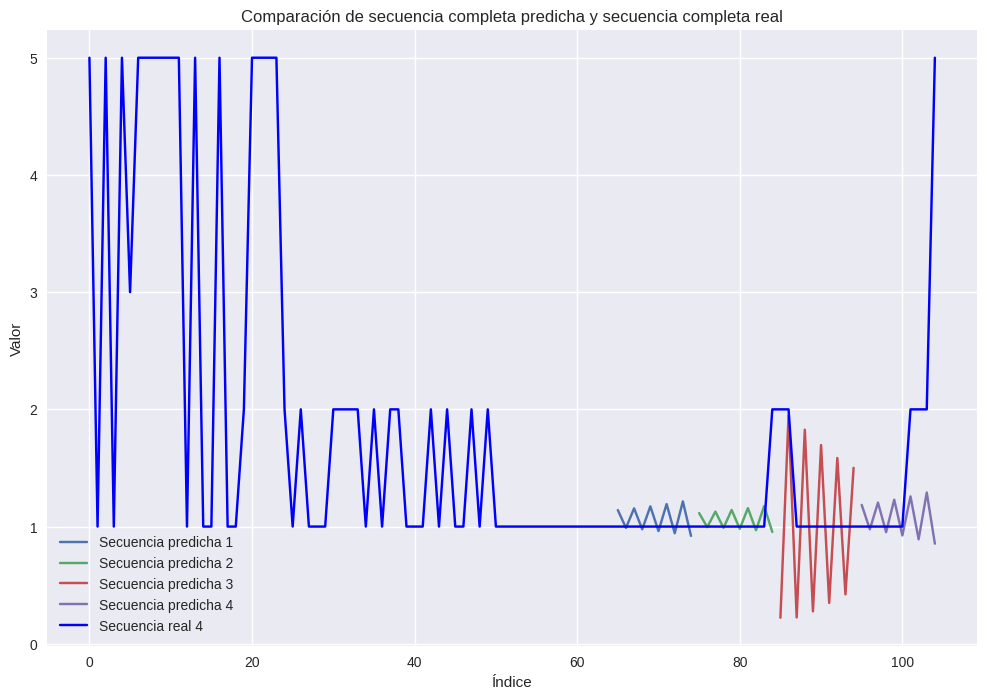

In [ ]:
plot_secuencias_multiples(prediction_seqs, window_size, dataset_training, prediction_len)

In [ ]:
sequence_length = 65
output_steps = 1
batch_size = 1
prediction_len = 40
window_size = sequence_length
n_sequences = None

In [ ]:
prediction_seqs = prediccion_secuencias_multiples(prediction_len, dataset_training, output_steps, window_size, n_sequences)

In [ ]:
plot_secuencias_multiples_interactivo(prediction_seqs, window_size, dataset_training, prediction_len)

In [ ]:
sequence_length = 65
output_steps = 1
batch_size = 1
window_size = sequence_length
n_predicciones = 305

In [ ]:
prediction_seqs2 = prediccion_secuencia_completa(n_predicciones, dataset_training, output_steps, window_size)

In [ ]:
len(prediction_seqs2)

305

In [ ]:
plot_secuencia_completa_interactivo(prediction_seqs2, window_size, dataset_training)

## Predicción testing 2017

In [ ]:
# Cargar el modelo desde el archivo h5
loaded_model = load_model('/content/drive/MyDrive/TFG_modelado/LSTM Diferido/Regresion/One-Step/One_step_stateful_WT1.h5')

In [ ]:
sequence_length = 13
output_steps = 1
batch_size = 1
prediction_len = 40
window_size = sequence_length
n_sequences = 4

In [ ]:
prediction_seqs = prediccion_secuencias_multiples(prediction_len, dataset_testing, output_steps, window_size, n_sequences)

In [ ]:
len(prediction_seqs)

5

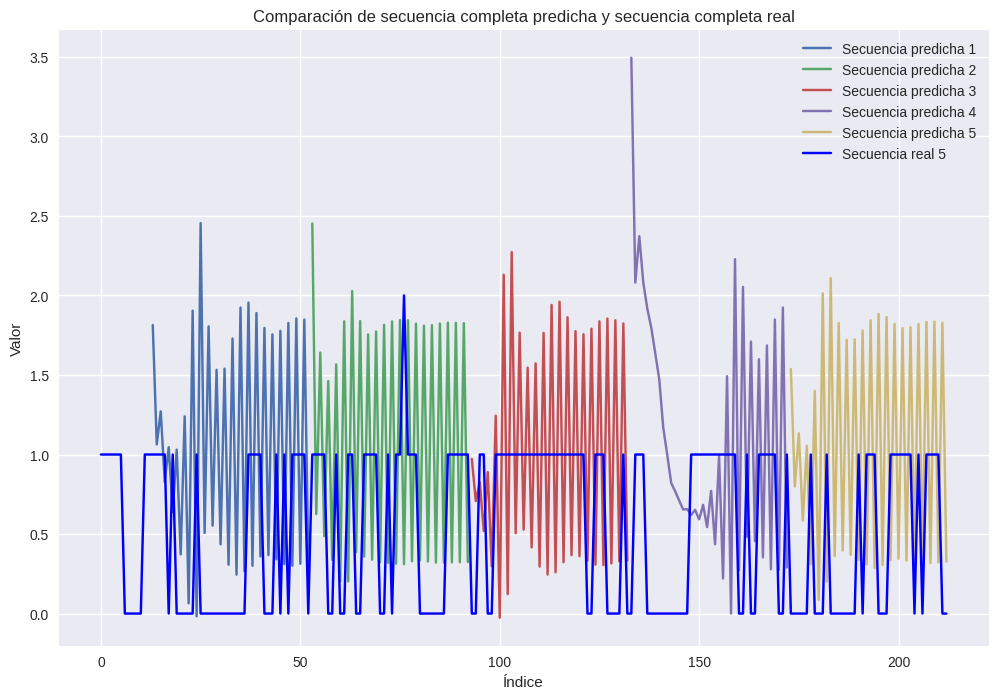

In [ ]:
plot_secuencias_multiples(prediction_seqs, window_size, dataset_testing, prediction_len)

In [ ]:
sequence_length = 13
output_steps = 1
batch_size = 1
prediction_len = 40
window_size = sequence_length
n_sequences = None

In [ ]:
prediction_seqs = prediccion_secuencias_multiples(prediction_len, dataset_testing, output_steps, window_size, n_sequences)

In [ ]:
plot_secuencias_multiples_interactivo(prediction_seqs, window_size, dataset_testing, prediction_len)

# Comprobaciones dataset

**Estudio numero de etiquetas de la turbina eolica 1 (training, testing)**

In [ ]:
print("### ESTUDIO WT1 ETIQUETAS")
# Obtener los valores únicos y sus recuentos
unique_values, counts = np.unique(dataset_testing, return_counts=True)

# Imprimir los resultados
print("Numero de etiquetas del conjunto de testing")
for value, count in zip(unique_values, counts):
    print(f"El valor {value} aparece {count} veces en el dataset_testing")

print("")

df_2016 = df_training[df_training['Fecha_Inicio'].dt.year == 2016]

# Contar el número de valores únicos en la columna "etiqueta_rendimiento"
conteo_valores = df_2016['etiqueta_rendimiento'].value_counts()

# Imprimir los resultados
print("Número de valores diferentes en la columna 'etiqueta_rendimiento' para el año 2016:")
print(conteo_valores)

print("")

df_2016 = df_training

# Contar el número de valores únicos en la columna "etiqueta_rendimiento"
conteo_valores = df_2016['etiqueta_rendimiento'].value_counts()

# Imprimir los resultados
print("Número de valores diferentes en la columna 'etiqueta_rendimiento' de la turbina eolica 1")
print(conteo_valores)

### ESTUDIO WT1 ETIQUETAS
Numero de etiquetas del conjunto de testing
El valor 0 aparece 344 veces en el dataset_testing
El valor 1 aparece 423 veces en el dataset_testing
El valor 2 aparece 2 veces en el dataset_testing

Número de valores diferentes en la columna 'etiqueta_rendimiento' para el año 2016:
1    3051
0    1021
2      16
5       7
3       1
4       1
Name: etiqueta_rendimiento, dtype: int64

Número de valores diferentes en la columna 'etiqueta_rendimiento' de la turbina eolica 1
1    24276
0     4514
2     1263
5      214
4       92
3       39
Name: etiqueta_rendimiento, dtype: int64


**Estudio etiquetas todo el dataset generado por la unet de Carlos**

In [ ]:
df['Fecha_Inicio'] = pd.to_datetime(df['Fecha_Inicio'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 791355 entries, 0 to 791354
Data columns (total 4 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   etiqueta_rendimiento  791355 non-null  int64         
 1   Id                    791355 non-null  int64         
 2   Fecha_Inicio          791355 non-null  datetime64[ns]
 3   Fecha_Fin             791355 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 24.2+ MB


In [ ]:
# Calcular el conteo de etiquetas por turbina
conteo_etiquetas_por_turbina = df.groupby(['Id', 'etiqueta_rendimiento'])['etiqueta_rendimiento'].count()

# Convertir la serie en un DataFrame y reorganizarlo como una tabla pivote
conteo_etiquetas_por_turbina_df = conteo_etiquetas_por_turbina.reset_index(name='conteo')
conteo_etiquetas_por_turbina_pivot = conteo_etiquetas_por_turbina_df.pivot_table(index='Id', columns='etiqueta_rendimiento', values='conteo', fill_value=0)

# Mostrar el DataFrame pivote
print(conteo_etiquetas_por_turbina_pivot)

etiqueta_rendimiento     0      1     2     3    4    5
Id                                                     
1                     4858  24699  1265    39   92  214
2                     3094  34454  4986   448  228  530
3                     2937  26698  6764   689  168  217
4                     4483  24058  2095   151  120  339
5                     4232  23843  2143   254  112  349
6                     5488  28897  2119   135  124  187
7                     3188  24105  2884   244  132  315
8                     1312  29126  5622   513  151  218
9                     3046  30705  2595   123  127  251
10                     149  21441  7319  1111  250  330
11                     906  16968  5657   720  239  221
12                    5266  18434   795    47   71  124
13                    2385  20732  1353    93  122  156
14                    7179  28712   681    69  161  463
15                    6021  23558   896    96  131  277
16                    1852  23023  5521   229  1

In [ ]:
print("Valores de etiquetas de todas las turbinas eolicas en 2017")
df['Fecha_Inicio'] = pd.to_datetime(df['Fecha_Inicio'])
df_2017 = df[df['Fecha_Inicio'].dt.year == 2017]

# Agrupar por el identificador de la turbina eólica y la etiqueta de rendimiento, contar el número de ocurrencias
conteo_etiquetas_por_turbina_2017 = df_2017.groupby(['Id', 'etiqueta_rendimiento']).size().reset_index(name='conteo')

# Pivoteando el DataFrame
pivot_df = conteo_etiquetas_por_turbina_2017.pivot(index='Id', columns='etiqueta_rendimiento', values='conteo').fillna(0)

# Mostrar el DataFrame pivoteado
print(pivot_df)

Valores de etiquetas de todas las turbinas eolicas en 2017
etiqueta_rendimiento      0      1     2    3    4     5
Id                                                      
1                     344.0  423.0   2.0  0.0  0.0   0.0
2                     271.0  794.0   1.0  0.0  1.0   7.0
3                     313.0  597.0   5.0  0.0  2.0   4.0
4                     331.0  434.0   0.0  0.0  0.0   2.0
5                     330.0  403.0   0.0  0.0  0.0  34.0
6                     408.0  497.0   0.0  0.0  0.0  15.0
7                     311.0  437.0   0.0  0.0  0.0  20.0
8                     142.0  771.0   2.0  0.0  0.0   6.0
9                     183.0  726.0   0.0  0.0  0.0  11.0
10                     19.0  666.0  18.0  0.0  1.0  63.0
11                     97.0  503.0  11.0  0.0  1.0   2.0
12                    357.0  256.0   0.0  0.0  0.0   0.0
13                    241.0  372.0   0.0  0.0  0.0   1.0
14                    446.0  348.0   0.0  0.0  0.0  95.0
15                    458.0  

In [ ]:
print("Valores de etiquetas de todas las turbinas eolicas en 2016")
df['Fecha_Inicio'] = pd.to_datetime(df['Fecha_Inicio'])
df_2016 = df[df['Fecha_Inicio'].dt.year == 2016]

# Agrupar por el identificador de la turbina eólica y la etiqueta de rendimiento, contar el número de ocurrencias
conteo_etiquetas_por_turbina_2016 = df_2016.groupby(['Id', 'etiqueta_rendimiento']).size().reset_index(name='conteo')

# Pivoteando el DataFrame
pivot_df = conteo_etiquetas_por_turbina_2016.pivot(index='Id', columns='etiqueta_rendimiento', values='conteo').fillna(0)

# Mostrar el DataFrame pivoteado
print(pivot_df)

Valores de etiquetas de todas las turbinas eolicas en 2016
etiqueta_rendimiento       0       1      2     3     4      5
Id                                                            
1                     1021.0  3051.0   16.0   1.0   1.0    7.0
2                      471.0  4908.0   85.0  15.0  58.0  172.0
3                      769.0  4004.0   43.0   5.0   4.0    7.0
4                      976.0  3085.0   15.0   2.0   4.0   14.0
5                      907.0  3114.0   21.0   2.0   0.0   51.0
6                     1174.0  3708.0   18.0   0.0   0.0   13.0
7                      743.0  3305.0   32.0   2.0   4.0   10.0
8                      216.0  4552.0   85.0   5.0   2.0   54.0
9                      509.0  4246.0   32.0   4.0  14.0   15.0
10                      28.0  3907.0  103.0  18.0   5.0   26.0
11                     213.0  2930.0   60.0   7.0   3.0   15.0
12                    1130.0  2145.0    5.0   0.0   0.0    0.0
13                     505.0  2756.0   17.0   2.0   0.0    

**Estudio dataset real de imagenes**

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/TFG_modelado/datasets/imagenes_etiquetadas_8x8-002.csv')

In [ ]:
df2.loc[df2['label'] != 5, 'label'] += 1

In [ ]:
# Calcular el conteo de etiquetas por turbina
conteo_etiquetas_por_turbina = df2.groupby(['Id', 'label'])['label'].count()

# Convertir la serie en un DataFrame y reorganizarlo como una tabla pivote
conteo_etiquetas_por_turbina_df = conteo_etiquetas_por_turbina.reset_index(name='conteo')
conteo_etiquetas_por_turbina_pivot = conteo_etiquetas_por_turbina_df.pivot_table(index='Id', columns='label', values='conteo', fill_value=0)

# Mostrar el DataFrame pivote
print(conteo_etiquetas_por_turbina_pivot)

label     0      1     2    3    4    5
Id                                     
1      3685  26480   743   19   76  164
2       818  39202  2934  227  135  424
3      1001  31280  4539  391  103  159
4      2876  26644  1314   71   71  270
5      2677  26432  1308  145   77  294
6      3420  32247  1017   70   70  126
7      1421  27542  1434  135   77  259
8       289  32455  3654  279   93  172
9      1128  34134  1290   48   69  178
10       49  23492  6015  619  157  268
11      159  19859  3917  425  171  180
12     4091  20127   354   23   56   86
13      828  23208   567   29   82  127
14     5701  30722   352   32   89  369
15     4725  25429   488   44   74  219
16      432  26917  3278  132   95  163
17     4797  30268  1390   55  112  400
18     4312  25339   800   29   72  193
19     2251  21484   645   40   54  181
20     1486  37701  3320  164  112  218
21     2877  20930   528   25   69  113
22     2435  15760   161   23   37   67
23     1293  28490   744   78   72  184


In [ ]:
# Filtrar las filas correspondientes al año 2017
df2['Fecha_Inicio'] = pd.to_datetime(df2['Fecha_Inicio'])

df_2017 = df2[df2['Fecha_Inicio'].dt.year == 2017]

# Calcular el conteo de etiquetas por turbina para el año 2017
conteo_etiquetas_por_turbina_2017 = df_2017.groupby(['Id', 'label'])['label'].count()

# Convertir la serie en un DataFrame y reorganizarlo como una tabla pivote
conteo_etiquetas_por_turbina_2017_df = conteo_etiquetas_por_turbina_2017.reset_index(name='conteo')
conteo_etiquetas_por_turbina_2017_pivot = conteo_etiquetas_por_turbina_2017_df.pivot_table(index='Id', columns='label', values='conteo', fill_value=0)

# Mostrar el DataFrame pivote
print(conteo_etiquetas_por_turbina_2017_pivot)


label    0     1  2  4   5
Id                        
1      293   476  0  0   0
2       68  1003  2  0   1
3      120   801  0  0   0
4      260   507  0  0   0
5      222   515  0  0  30
6      253   659  0  0   8
7      135   616  0  0  17
8       36   883  0  0   2
9       57   859  0  0   4
10       7   695  6  0  59
11      22   590  2  0   0
12     320   293  0  0   0
13     104   508  2  0   0
14     404   392  0  0  93
15     413   355  0  0   0
16      67   699  1  0   0
17     492   423  0  0   5
18     377   349  0  1  41
19     236   378  1  0   0
20     172   849  2  0  51
21     255   359  0  0   0
22     205   246  0  0   8
23     177   591  0  0   0
24     231   366  0  0  15
25     190   696  2  1  31


In [ ]:
# Filtrar las filas correspondientes al año 2016
df2['Fecha_Inicio'] = pd.to_datetime(df2['Fecha_Inicio'])

df_2016 = df2[df2['Fecha_Inicio'].dt.year == 2016]

# Calcular el conteo de etiquetas por turbina para el año 2016
conteo_etiquetas_por_turbina_2016 = df_2016.groupby(['Id', 'label'])['label'].count()

# Convertir la serie en un DataFrame y reorganizarlo como una tabla pivote
conteo_etiquetas_por_turbina_2016_df = conteo_etiquetas_por_turbina_2016.reset_index(name='conteo')
conteo_etiquetas_por_turbina_2016_pivot = conteo_etiquetas_por_turbina_2016_df.pivot_table(index='Id', columns='label', values='conteo', fill_value=0)

# Mostrar el DataFrame pivote
print(conteo_etiquetas_por_turbina_2016_pivot)

label     0     1   2  3   4    5
Id                               
1       789  3294   8  0   0    6
2       129  5338  60  5  29  148
3       300  4507  19  1   0    5
4       653  3424   8  2   0    9
5       540  3494  15  0   0   46
6       712  4188   6  0   0    7
7       358  3718  11  0   3    6
8        44  4786  37  1   1   45
9       144  4642  14  0   8   12
10       13  4005  45  4   2   18
11       42  3144  30  0   1   11
12      915  2361   4  0   0    0
13      167  3106   7  0   0    0
14     1311  3600   4  0   0    5
15     1118  2974   5  0   0    2
16       76  3963  17  0   1   43
17     1250  3635  14  0   0   18
18     1061  3030   6  0   0    3
19      595  2677   8  0   0    0
20      324  5385  13  0   2   16
21      682  2593   4  0   0    0
22      536  1898   6  0   0   11
23      293  3752   9  0   0   46
24      510  2749  10  0   0   11
25      356  4543  19  2   0    0
